In [1]:
%matplotlib inline


# Fit using the Model interface

This notebook shows a simple example of using the ``lmfit.Model`` class. For
more information please refer to:
https://lmfit.github.io/lmfit-py/model.html#the-model-class.


In [2]:
import numpy as np
from pandas import Series

from lmfit import Model, Parameter, report_fit

The ``Model`` class is a flexible, concise curve fitter. I will illustrate
fitting example data to an exponential decay.



In [3]:
def decay(t, N, tau):
    return N*np.exp(-t/tau)

The parameters are in no particular order. We'll need some example data. I
will use ``N=7`` and ``tau=3``, and add a little noise.



In [4]:
t = np.linspace(0, 5, num=1000)
np.random.seed(2021)
data = decay(t, 7, 3) + np.random.randn(t.size)

**Simplest Usage**



In [18]:
model = Model(decay, independent_vars=['t'])
result = model.fit(data, t=t, N=10, tau=1)

In [35]:
result.params['N'].value

7.146693290745707

In [41]:
result

The Model infers the parameter names by inspecting the arguments of the
function, ``decay``. Then I passed the independent variable, ``t``, and
initial guesses for each parameter. A residual function is automatically
defined, and a least-squared regression is performed.

We can immediately see the best-fit values:



In [33]:
print(result.values)

{'N': 7.146693290745707, 'tau': 2.8980288907359197}


and use these best-fit parameters for plotting with the ``plot`` function:



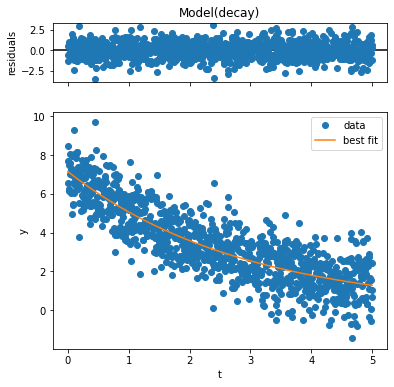

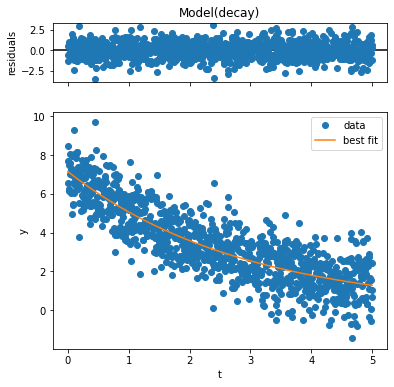

In [7]:
result.plot()

We can review the best-fit `Parameters` by accessing `result.params`:



In [8]:
result.params.pretty_print()

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
N       7.147     -inf      inf   0.0913     True     None     None
tau     2.898     -inf      inf  0.06299     True     None     None


In [30]:
result.params['N'].stderr

0.09130441710371619

More information about the fit is stored in the result, which is an
``lmfit.MimimizerResult`` object (see:
https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.MinimizerResult)



**Specifying Bounds and Holding Parameters Constant**

Above, the ``Model`` class implicitly builds ``Parameter`` objects from
keyword arguments of ``fit`` that match the arguments of ``decay``. You can
build the ``Parameter`` objects explicitly; the following is equivalent.



In [9]:
result = model.fit(data, t=t,
                   N=Parameter('N', value=10),
                   tau=Parameter('tau', value=1))
report_fit(result.params)

[[Variables]]
    N:    7.14669329 +/- 0.09130442 (1.28%) (init = 10)
    tau:  2.89802889 +/- 0.06299097 (2.17%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(N, tau) = -0.753


By building ``Parameter`` objects explicitly, you can specify bounds
(``min``, ``max``) and set parameters constant (``vary=False``).



In [10]:
result = model.fit(data, t=t,
                   N=Parameter('N', value=7, vary=False),
                   tau=Parameter('tau', value=1, min=0))
report_fit(result.params)

[[Variables]]
    N:    7 (fixed)
    tau:  2.97663124 +/- 0.04347450 (1.46%) (init = 1)


**Defining Parameters in Advance**

Passing parameters to ``fit`` can become unwieldy. As an alternative, you
can extract the parameters from ``model`` like so, set them individually,
and pass them to ``fit``.



In [11]:
params = model.make_params()

params['N'].value = 10
params['tau'].value = 1
params['tau'].min = 0

result = model.fit(data, params, t=t)
report_fit(result.params)

[[Variables]]
    N:    7.14669328 +/- 0.09130441 (1.28%) (init = 10)
    tau:  2.89802890 +/- 0.06299102 (2.17%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(N, tau) = -0.753


Keyword arguments override ``params``, resetting ``value`` and all other
properties (``min``, ``max``, ``vary``).



In [12]:
result = model.fit(data, params, t=t, tau=1)
report_fit(result.params)

[[Variables]]
    N:    7.14669328 +/- 0.09130441 (1.28%) (init = 10)
    tau:  2.89802890 +/- 0.06299102 (2.17%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(N, tau) = -0.753


The input parameters are not modified by ``fit``. They can be reused,
retaining the same initial value. If you want to use the result of one fit
as the initial guess for the next, simply pass ``params=result.params``.



#TODO/FIXME: not sure if there ever way a "helpful exception", but currently
#it raises a ``ValueError: The input contains nan values``.

#*A Helpful Exception*

#All this implicit magic makes it very easy for the user to neglect to set a
#parameter. The ``fit`` function checks for this and raises a helpful exception.



In [13]:
# #result = model.fit(data, t=t, tau=1)  # N unspecified

#An *extra* parameter that cannot be matched to the model function will
#throw a ``UserWarning``, but it will not raise, leaving open the possibility
#of unforeseen extensions calling for some parameters.



*Weighted Fits*

Use the ``sigma`` argument to perform a weighted fit. If you prefer to think
of the fit in term of ``weights``, ``sigma=1/weights``.



In [14]:
weights = np.arange(len(data))
result = model.fit(data, params, t=t, weights=weights)
report_fit(result.params)

[[Variables]]
    N:    6.98535246 +/- 0.28002506 (4.01%) (init = 10)
    tau:  2.97268207 +/- 0.11134751 (3.75%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(N, tau) = -0.931


*Handling Missing Data*

By default, attempting to fit data that includes a ``NaN``, which
conventionally indicates a "missing" observation, raises a lengthy exception.
You can choose to ``omit`` (i.e., skip over) missing values instead.



In [15]:
data_with_holes = data.copy()
data_with_holes[[5, 500, 700]] = np.nan  # Replace arbitrary values with NaN.

model = Model(decay, independent_vars=['t'], nan_policy='omit')
result = model.fit(data_with_holes, params, t=t)
report_fit(result.params)

[[Variables]]
    N:    7.15448808 +/- 0.09181826 (1.28%) (init = 10)
    tau:  2.89285076 +/- 0.06305979 (2.18%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(N, tau) = -0.754


If you don't want to ignore missing values, you can set the model to raise
proactively, checking for missing values before attempting the fit.

Uncomment to see the error
#model = Model(decay, independent_vars=['t'], nan_policy='raise')
#result = model.fit(data_with_holes, params, t=t)

The default setting is ``nan_policy='raise'``, which does check for NaNs and
raises an exception when present.

Null-checking  relies on ``pandas.isnull`` if it is available. If pandas
cannot be imported, it silently falls back on ``numpy.isnan``.



*Data Alignment*

Imagine a collection of time series data with different lengths. It would be
convenient to define one sufficiently long array ``t`` and use it for each
time series, regardless of length. ``pandas``
(https://pandas.pydata.org/pandas-docs/stable/) provides tools for aligning
indexed data. And, unlike most wrappers to ``scipy.leastsq``, ``Model`` can
handle pandas objects out of the box, using its data alignment features.

Here I take just a slice of the ``data`` and fit it to the full ``t``. It is
automatically aligned to the correct section of ``t`` using Series' index.



In [16]:
model = Model(decay, independent_vars=['t'])
truncated_data = Series(data)[200:800]  # data points 200-800
t = Series(t)  # all 1000 points
result = model.fit(truncated_data, params, t=t)
report_fit(result.params)

[[Variables]]
    N:    7.10725874 +/- 0.24259174 (3.41%) (init = 10)
    tau:  2.92503558 +/- 0.13481757 (4.61%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(N, tau) = -0.932


Data with missing entries and an unequal length still aligns properly.



In [17]:
model = Model(decay, independent_vars=['t'], nan_policy='omit')
truncated_data_with_holes = Series(data_with_holes)[200:800]
result = model.fit(truncated_data_with_holes, params, t=t)
report_fit(result.params)

[[Variables]]
    N:    7.11270203 +/- 0.24334999 (3.42%) (init = 10)
    tau:  2.92065221 +/- 0.13488198 (4.62%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(N, tau) = -0.932


In [88]:
import string
import random
def id_generator(size=17, chars=string.ascii_letters + string.digits + string.punctuation):
    return ''.join(random.choice(chars) for _ in range(size))

In [90]:
id_generator(size=100)

')X5h^c:-?d5UH=Rm-]WE:h|*|kFXy)%,l(,R_76>k&>ZL(%;]pz]HvA.k"q?@xh&("(SRUv]?*}e_~9U,=z\\:cj8CVos-"!<jI?p'

In [58]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [95]:
import secrets

password_length = 20
print(secrets.token_urlsafe(password_length))

GWHEmnbK7j5rGvcbEAx-dOe9x6s


In [93]:
# import M2Crypto
# import string

# def random_password(length=10):
#     chars = string.ascii_uppercase + string.digits + string.ascii_lowercase
#     password = ''
#     for i in range(length):
#         password += chars[ord(M2Crypto.m2.rand_bytes(1)) % len(chars)]
#     return password